In [45]:
pip install numpy pandas scikit-learn tensorflow matplotlib

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [49]:
# Load the weather data
data = pd.read_csv('/content/weather data cleaned.csv')

# Convert the Year, Month, Day columns into a single datetime column
data['date'] = pd.to_datetime(data["Date"],dayfirst=True)
data.set_index('date', inplace=True)
data.drop(columns=["Date"], inplace=True)


# Select features for prediction
features = ['Min Temp', 'Max Temp', 'Humidity', 'Precipitation']
data = data[features]

# Scale the data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]


In [50]:
train_data , test_data

(            Min Temp  Max Temp  Humidity  Precipitation
 date                                                   
 2000-01-01  0.382166  0.300699  0.483333       0.000000
 2000-01-02  0.414013  0.335664  0.450000       0.000000
 2000-01-03  0.382166  0.307692  0.500000       0.000000
 2000-01-04  0.350318  0.300699  0.500000       0.000000
 2000-01-05  0.350318  0.300699  0.500000       0.000000
 ...              ...       ...       ...            ...
 2019-10-21  0.828025  0.594406  0.700000       0.002028
 2019-10-22  0.834395  0.573427  0.700000       0.002028
 2019-10-23  0.786624  0.566434  0.766667       0.078296
 2019-10-24  0.700637  0.328671  0.933333       0.225152
 2019-10-25  0.700637  0.335664  0.966667       0.129006
 
 [7000 rows x 4 columns],
             Min Temp  Max Temp  Humidity  Precipitation
 date                                                   
 2019-10-26  0.726115  0.384615  0.883333       0.028398
 2019-10-27  0.719745  0.482517  0.766667       0.004057
 20

In [51]:
# Create sequences
def create_sequences(data, sequence_length, prediction_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        seq = data.iloc[i:i + sequence_length].values
        label = data.iloc[i + sequence_length: i + sequence_length + prediction_length].values
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define sequence and prediction lengths
sequence_length = 90  # Input sequence (e.g., past 90 days)
prediction_length = 90  # Predict the next 90 days

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, sequence_length, prediction_length)
X_test, y_test = create_sequences(test_data, sequence_length, prediction_length)

# Ensure the data type is float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Check the shape of the generated sequences and labels
print("X_train shape:", X_train.shape)  # Should be (samples, sequence_length, num_features)
print("y_train shape:", y_train.shape)  # Should be (samples, prediction_length, num_features)


X_train shape: (6821, 90, 4)
y_train shape: (6821, 90, 4)


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [53]:
# Define the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer
model.add(LSTM(400, return_sequences=True))  # LSTM with return_sequences=True
model.add(Dropout(0.1))

model.add(LSTM(200, return_sequences=True))  # Another LSTM layer
model.add(Dropout(0.1))

model.add(LSTM(100, return_sequences=False))  # Another LSTM layer
model.add(Dropout(0.1))

model.add(Dense(prediction_length * X_train.shape[2]))  # Adjust based on total outputs // output layer
model.add(tf.keras.layers.Reshape((prediction_length, X_train.shape[2])))  # Reshape to (90, 5)

# Compile the model with a lower learning rate (e.g., 0.0005)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Summary of the model
model.summary()

# Set up callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 90, 400)        │       648,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 90, 400)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 90, 200)        │       480,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 90, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 360)            │        36,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 90, 4)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,285,560 (4.90 MB)

 Trainable params: 1,285,560 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Train the model and save the history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.1780 - val_loss: 0.0214
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0317 - val_loss: 0.0185
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0239 - val_loss: 0.0143
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0183 - val_loss: 0.0130
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0157 - val_loss: 0.0124
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0135 - val_loss: 0.0105
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0120 - val_loss: 0.0104
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0110 - val_loss: 0.0097
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0103 - val_loss: 0.0092
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 12/50
214/214 ━━━━━━━━━━━━━━━━━━━

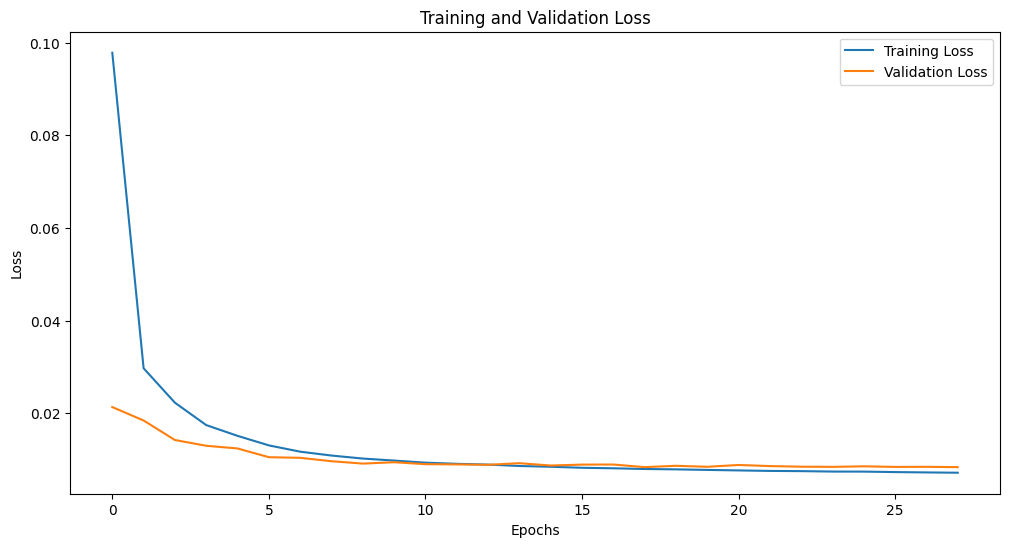

In [56]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))  # Optional: Set figure size
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


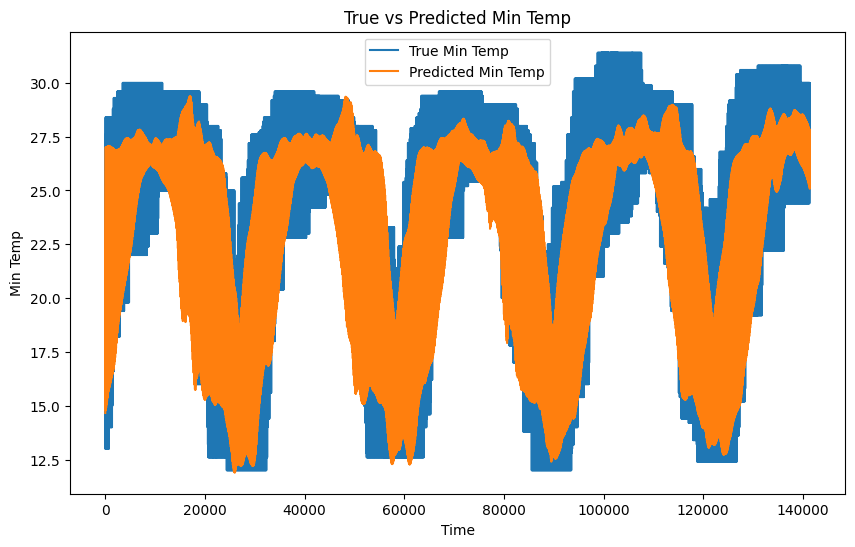

In [57]:
# Make predictions
predictions = model.predict(X_test)

# Reshape the predicted values to match the test data shape
predicted_data = predictions.reshape(-1, predictions.shape[-1])

# Rescale the predicted values back to their original scale
predicted_data_rescaled = scaler.inverse_transform(predicted_data)

# Reshape the test data to match the predicted shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])

# Rescale the test data back to its original scale for comparison
true_data_rescaled = scaler.inverse_transform(y_test_reshaped)

# Plot the actual vs predicted values for one feature (e.g., Min Temp)
plt.figure(figsize=(10, 6))
plt.plot(true_data_rescaled[:, 0], label='True Min Temp')
plt.plot(predicted_data_rescaled[:, 0], label='Predicted Min Temp')
plt.title('True vs Predicted Min Temp')
plt.xlabel('Time')
plt.ylabel('Min Temp')
plt.legend()
plt.show()


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Reshape the test and predicted data
predicted_data = predictions.reshape(-1, predictions.shape[-1])
true_data_reshaped = y_test.reshape(-1, y_test.shape[-1])

# Rescale the predicted and true data back to their original scales
predicted_data_rescaled = scaler.inverse_transform(predicted_data)
true_data_rescaled = scaler.inverse_transform(true_data_reshaped)

# Calculate the errors for one feature (e.g., Min Temp, which is index 0)
mae = mean_absolute_error(true_data_rescaled[:, 0], predicted_data_rescaled[:, 0])
rmse = np.sqrt(mean_squared_error(true_data_rescaled[:, 0], predicted_data_rescaled[:, 0]))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 1.787676215171814
Root Mean Squared Error (RMSE): 2.234849892680974


In [59]:
# Use the last sequence from the test data to predict future weather
last_sequence = X_test[-1].reshape(1, X_test.shape[1], X_train.shape[2])  # Ensure correct shape

# Predict future weather (for the next 90 days, for example)
future_prediction = model.predict(last_sequence)

# Reshape the predicted data to 2D for inverse transformation (batch size is 1, so we remove it)
future_prediction_reshaped = future_prediction.reshape(future_prediction.shape[1], future_prediction.shape[2])

# Inverse transform the prediction back to the original scale
future_weather = scaler.inverse_transform(future_prediction_reshaped)

print(f"Predicted future weather for the next 90 days: \n{future_weather}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted future weather for the next 90 days: 
[[27.68916   33.479473  84.72372    7.989244 ]
 [27.73474   33.507725  84.04558    9.886766 ]
 [27.593443  33.46585   84.85126   11.579662 ]
 [27.639505  33.69175   83.8724    11.234317 ]
 [27.212372  33.977715  84.093475   9.19515  ]
 [27.721643  33.378418  84.694214  10.397367 ]
 [27.482424  33.518513  83.930504  10.385225 ]
 [26.996353  33.052876  84.793076  12.205571 ]
 [27.526     33.30795   83.88862   10.92792  ]
 [27.325716  33.352596  85.0054    11.635012 ]
 [26.996088  33.33178   84.175934  11.265427 ]
 [26.88749   33.482903  84.0895    11.71505  ]
 [27.826498  33.048733  84.11639   10.40394  ]
 [27.454147  33.32221   84.904175   9.499426 ]
 [27.51635   33.355957  84.25062    8.963096 ]
 [27.41398   33.11906   85.10373   11.383503 ]
 [27.450329  32.98871   85.322395  10.421626 ]
 [27.26228   33.20804   84.59306   10.948144 ]
 [27.366495  33.25595   85.4885    10.244616 ]
 [27.362143  33.03035